# Differentiating notebooks and books

The project's proposal is to differentiate between notebooks and books, which despite their similarity, one has content and the other does not. After training a model, deploy it on Hugging Face for testing

## Downloading the requirements

In [56]:
# Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")
    
# Make sure we've got the latest version of fastai:
!pip install -Uqq fastai duckduckgo_search

## Importing the libraries

In [57]:
from fastai.vision.all import *
from duckduckgo_search import ddg_images
from fastdownload import download_url

## Defining the search string and the function that does the search in duckduckgo

In [58]:
# Declaring the texts that are going to be used to find images from DuckDuckGo
search_string = 'book','paper notebook'

# The function uses the ddg_images function from the duckduckgo_search package to search for images related to the term.
#  It passes the term and max_results parameters to the ddg_images function to retrieve the image URLs.
#  The function returns the list of image URLs and also prints a message indicating the search term that was used.
def search_images(term, max_images=80):
    print(f"Searching for '{term}'\n\n")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Example of a book photo

Searching for 'book photos'




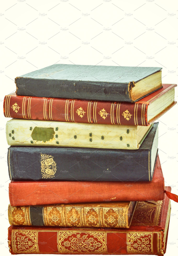

In [59]:
urls = search_images(search_string[0] + ' photos', max_images=1)

# book
dest = search_string[0] + '.jpg'
download_url(urls[0], dest, show_progress=False)

Image.open(dest).to_thumb(256,256)

### Example of a notebook photo

Searching for 'paper notebook photos'




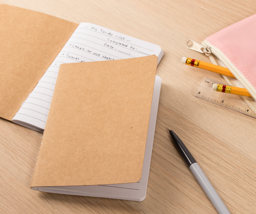

In [60]:
urls = search_images(search_string[1] + ' photos', max_images=1)

# person wearing facemask
dest = search_string[1] + '.jpg'
download_url(urls[0], dest, show_progress=False)
Image.open(dest).to_thumb(256,256)

## Download images to be used on the training and validation of the model, separated by the folder name

In [61]:
path = Path('book_or_notebook')

for label in search_string:
    dest = (path/label)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{label} photo', 100))
    resize_images(path/label, max_size=400, dest=path/label)

print('OK!\n')

Searching for 'book photo'


Searching for 'paper notebook photo'


OK!



### Removing corrupted images (failed images)

In [62]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

## Create the DataBlock with the images downloaded and organizing it to feed them to the learner

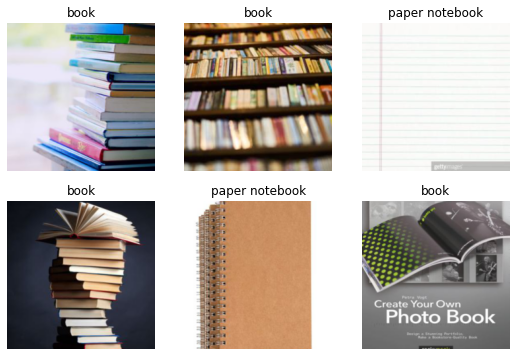

In [63]:
book_or_notebook = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=37),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
).dataloaders(path, bs=32)

book_or_notebook.show_batch(max_n=6)

## Training the pre-trained model with our data

In [64]:
learn = vision_learner(book_or_notebook, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.713100,0.202069,0.055046,00:04


epoch,train_loss,valid_loss,error_rate,time
0,0.098709,0.023964,0.009174,00:04
1,0.069180,0.003816,0.000000,00:05
2,0.053308,0.002167,0.000000,00:04
3,0.051602,0.001562,0.000000,00:04


## Export our project to be used on Hugging Face

In [65]:
learn.export('model.pkl')

## Deploy

Acesse o link abaixo para testar o modelo no Hugging Face

In [ ]:
https://huggingface.co/spaces/luisgaboardi/NotebookOrBook